<a href="https://colab.research.google.com/github/Cpt-Shaan/Summer_Intern_2024_IvLabs/blob/main/MNIST_SHaan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of the Hand-written digit recognition model (Using MNIST dataset) from scratch using Numpy and Matplotlib. Used a Simple 2 Layer ANN for the implementation.

Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Mounting the Drive to the runtime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Storing the Paths of the File for initialization. Dataset downloaded from https://yann.lecun.com/exdb/mnist/ and uploaded to Drive


In [ ]:
# Training Data
x_train = "/content/drive/MyDrive/MNIST/train-images.idx3-ubyte"
y_train = "/content/drive/MyDrive/MNIST/train-labels.idx1-ubyte"

# Testing Data
x_dev = "/content/drive/MyDrive/MNIST/t10k-images.idx3-ubyte"
y_dev = "/content/drive/MyDrive/MNIST/t10k-labels.idx1-ubyte"

Function to read the ubyte (Binary) files and create the x_train and y_train arrays

In [ ]:
def create_data(imgfile, labelfile, n):
  file1 = open(imgfile, 'rb')
  file2 = open(labelfile, 'rb')

  file1.read(16) # Data starts after that
  file2.read(8) # Data starts after that
  images = []
  labels = []
  for i in range(n):
    image = []
    for i in range(784):  # Size of Image (28*28)
      image.append(ord(file1.read(1)))  # Adding individual pixel values to the image list
    images.append(image)  # Adding the image to the images list
    labels.append(ord(file2.read(1)))

  file1.close()
  file2.close()

  return images, labels


In [ ]:
x_train, y_train = create_data( x_train, y_train, 60000)
x_dev, y_dev = create_data( x_dev, y_dev, 10000)

Converting to Numpy Arrays for easier manipulation.

In [ ]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_dev = np.asarray(x_dev)
y_dev = np.asarray(y_dev)

Showing a sample training label by plotting as an image in matplotlib

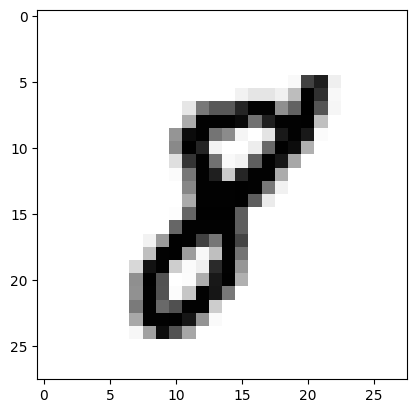

In [ ]:
sampla = x_train[17].reshape((28,28))
plt.imshow( sampla, cmap = 'Greys', interpolation = 'None')

Defining Functions for Working with the Neural Network.

Layer 1 : ReLu layer , 10 Nodes

Layer 2 (Output Layer) : Softmax , 10 Nodes

In [ ]:
def init_params():
  # Randomly initialzing trainable parameters and standardizing it
  w1 = np.random.rand(10, 784) - 0.5
  b1 = np.random.rand(10, 1) - 0.5
  w2 = np.random.rand(10,10) - 0.5
  b2 = np.random.rand(10,1) - 0.5
  return w1,b1,w2,b2

def Softmax(z):
  # Output activation Function for Multiclass Classification
  return np.exp(z)/sum(np.exp(z))

def ReLu(z):
  # Hidden Activation Function (Rectified Linear Unit)
  return np.maximum(z,0)

def Relu_deriv(z):
  return z > 0

def ForwardProp(w1,b1,w2,b2,x1):
  # One Forward Propagation step
  z1 = w1.dot(x1) + b1
  a1 = ReLu(z1)
  z2 = w2.dot(a1) + b2
  a2 = Softmax(z2)
  return a1,z1,a2,z2

def onehot_encode(y):
  # One Hot Encoding of the labels to convert to suitable output label
  one_hot_Y = np.zeros((y.size, y.max() + 1))
  one_hot_Y[np.arange(y.size), y] = 1
  one_hot_Y = one_hot_Y.T
  return one_hot_Y

def Cross_Entropy_Loss(y_hat, y, m, n):
  # Loss function for multi-class classification
  y = onehot_encode(y)
  loss = (1/m) * np.sum((-1/n)* np.sum(y * np.log(y_hat)))
  return loss

def BackProp(w1, b1, x1, z1, a1, w2, b2, z2, a2, y, m):
  # Backpropogation step
  # Calculating gradients at each step
  y = onehot_encode(y)
  dz2 = a2 - y
  dw2 = 1/m * dz2.dot(a1.T)
  db2 = 1/m * np.sum(dz2)
  dz1 = (w2.T).dot(dz2) * Relu_deriv(z1)
  dw1 = 1/m * dz1.dot(x1.T)
  db1 = 1/m * np.sum(dz1)
  return dw1, db1, dw2, db2

def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
  # Subtracting parameters by gradients to perform one step of gradient descent
  w1 = w1 - alpha * dw1
  b1 = b1 - alpha * db1
  w2 = w2 - alpha * dw2
  b2 = b2 - alpha * db2
  return w1, b1, w2, b2

def accuracy(a2, y):
  # Calculating accuracy
  predictions = np.argmax(a2, 0)
  return (np.sum(predictions == y) / y.size)*100

def train_model(x1, y, epochs, alpha, w1, b1, w2, b2, decay):
  m,n = x1.shape
  Loss = []
  Accuracy = []
  for i in range(1,epochs + 1):   # For every epoch running 1 step each of forward and backward prop
    a1,z1,a2,z2 = ForwardProp(w1,b1,w2,b2,x1)
    Loss.append( Cross_Entropy_Loss(a2,y,m,n) )
    Accuracy.append( accuracy(a2, y) )
    if (i%10 == 0 or i==1):
      # Printing Loss and Accuracy for every 10th Epoch
      print(f" Epoch no : {i} - Loss : {Cross_Entropy_Loss(a2,y,m,n)} , Accuracy : {accuracy(a2, y)}% ")
    dw1, db1, dw2, db2 = BackProp(w1, b1, x1, z1, a1, w2, b2, z2, a2, y, m)
    w1,b1,w2,b2 = update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
    alpha = (1/(1 + decay*i))*alpha # Learning Rate Decay
  return w1, b1, w2, b2, Loss, Accuracy


Making the input dimensions right by transposing

In [ ]:
x_train = x_train.T
x_dev = x_dev.T

Standardizing Inputs

In [ ]:
x_train = x_train / 255.
x_dev = x_dev / 255.

Initializing Parameters

In [ ]:
w1, b1, w2, b2 = init_params()

Creating lists to store accuracies and loss values at every training epoch , to further plot them against no of epochs.

In [ ]:
total_loss = list()
total_acc = list()

Training the Data

In [ ]:
w1, b1, w2, b2, Loss, Accuracy = train_model( x_train, y_train, 100, 0.006, w1, b1, w2, b2, 0 )

 Epoch no : 1 - Loss : 0.00026991903226128487 , Accuracy : 93.92666666666668% 
 Epoch no : 10 - Loss : 0.0002612262825645051 , Accuracy : 94.12166666666667% 
 Epoch no : 20 - Loss : 0.0002588092983258445 , Accuracy : 94.19166666666666% 
 Epoch no : 30 - Loss : 0.0002574753278820425 , Accuracy : 94.215% 
 Epoch no : 40 - Loss : 0.0002565830283141114 , Accuracy : 94.21166666666667% 
 Epoch no : 50 - Loss : 0.00025592660744036945 , Accuracy : 94.21666666666667% 
 Epoch no : 60 - Loss : 0.0002554145924315011 , Accuracy : 94.21000000000001% 
 Epoch no : 70 - Loss : 0.0002549928634186198 , Accuracy : 94.21666666666667% 
 Epoch no : 80 - Loss : 0.00025463209972883177 , Accuracy : 94.21666666666667% 
 Epoch no : 90 - Loss : 0.00025431544725282545 , Accuracy : 94.23666666666666% 
 Epoch no : 100 - Loss : 0.00025403027095500234 , Accuracy : 94.24166666666667% 


Adding data of all sub-training sessions.

In [ ]:
total_loss.extend(Loss)
total_acc.extend(Accuracy)

Plotting Loss v/s No of epochs

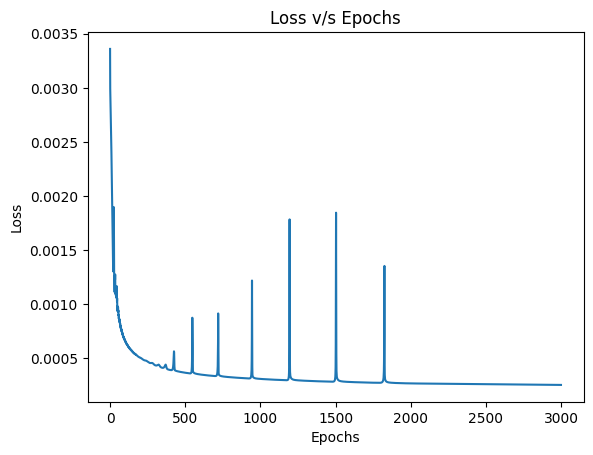

In [ ]:
iterations = np.linspace(0,3000,3000)
plt.plot(iterations, total_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epochs")
plt.show()

Plotting Accuracy v/s No of epochs

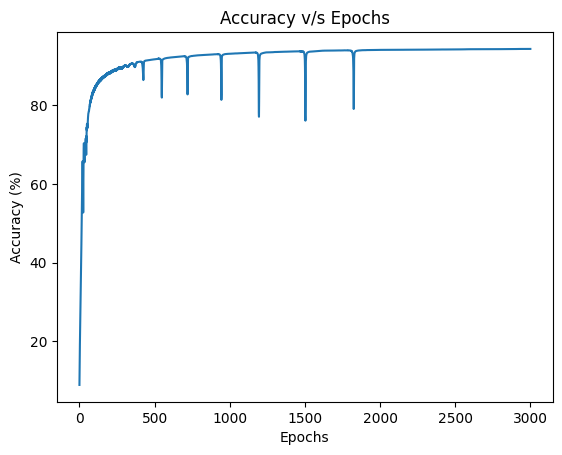

In [ ]:
plt.plot(iterations, total_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy v/s Epochs")
plt.show()

Function for Working with Testing Data

In [ ]:
def Testing(x_dev, y_dev, w1, b1, w2, b2):
  # Implementing only the forward propogation step in testing process
  m,n = x_dev.shape
  a1,z1,a2,z2 = ForwardProp(w1,b1,w2,b2,x_dev)
  loss = Cross_Entropy_Loss(a2, y_dev, m, n)
  acc = accuracy(a2, y_dev)
  return loss, acc

Testing the Data

In [ ]:
loss, acc = Testing(x_dev, y_dev, w1, b1, w2, b2)

Displaying the Test Data accuracy and Loss on the optimized Model

In [ ]:
print(f"Testing Data: Loss : {loss} , Accuracy : {acc}%")

Testing Data: Loss : 0.0002574034745165209 , Accuracy : 94.1%
